# Characterizing data distribution

#### We want to represent the dataset in a human-friendly format to get a good impression of it. This is a kind of dataset "identity card".

- Data format : autoML

In [1]:
datasets = {'iris': ('sample_data/iris', 'iris'),
            'iris_1': ('sample_data/iris_1', 'iris'),
            'iris_2': ('sample_data/iris_2', 'iris'),
            'mimic': ('sample_data/mimic_data', 'mimic'),
            'mushrooms': ('sample_data/mushrooms', 'mushrooms'),
            'chems': ('sample_data/chems', 'chems'),
            'credit': ('sample_data/credit_data', 'credit'),
            'squares': ('sample_data/squares', 'squares'),
            'squares_2': ('sample_data/squares_2', 'squares')}

input_dir, basename = datasets['iris']

## Characterization

### Visualization
- Scatter plot matrix
- Classes distribution
- Hierarchical clustering with heatmap matrix
- Hierarchical clustering with correlation matrix
- Principal components analysis (PCA)
- Linear discriminant analysis (LDA)
- T-distributed stochastic neighbor embedding (t-SNE algorithm)

### Meta features

- **Simple features, Simple Measurements or General Data Characteristic** are directly and easily accessible properties of the dataset wich need almost no computations such as number of classes or number of attributes.
    
    - Number of records: $n$
    - Number of attributes: $m$
    -  Number of classes: $q$
    -  Ratio of symbolic attributes: $\frac{m_{symb}}{m}$
    -  DatasetRatio $=\frac{NumberOfFeatures}{NumberOfInstances}$  
    -  Default error rate: $1 - Acc_{def}$ where $Acc_{def}$ is the probability of the largest class or default accuracy.
    -  Standard deviation of the class distribution: $\sigma_{class}$
    -  Relative probability of defective records: $\frac{n_{defTuple}}{n}$ where $n_{defTuple}$ is the number of records with missing values.
    -  Relative probability of missing values: $\frac{h_{missVal}}{n \times m}$ where $h_{missVal}$ is the number of missing values.

<br>   
- **Statistical features** use statistical analysis methods and tests (Engels and Theusinger, 1998; Sohn 1999).
    
    - Kurtosis: Fourth central moment divided by the square of the variance $\frac{E[(x_i-E[x_i])^4]}{[E[(x_i-E[x_i])^4]]^2}$ where $x_i$ is the ith feature. 
    - PCAKurtosis: Transform the dataset X by PCA, then compute the kurtosis
    - SkewnessMin: min over skewness of all features. Skewness measures the symmetry of a distribution. A skewness value > 0 means that there is more weight in the left tail of the distribution

<br> 
- **Discriminant Measurements** compute a discriminant analysis leading to the following measurements:
    
    -  Relative importance if the largest eigenvalue as an indication for the importance of the $1{\text{st}}$ discriminant function
    -  Canonical correlation, which is an indicator for the degree of correlation between the most significant discriminant function and class distribution. There is a strong correlation between the classes and the $1{\text{st}}$ discriminant function if this measurement is close to unity.
    -  Number of discriminant functions
    -  Wilks Lambda describes the significance of the r discriminant functions and is defined as follows:
        
        $$ \Lambda = \Pi^{DiscFct}_{j=1} \frac{1}{1 + \lambda_j} $$
        
        If Wlambda is near zero, in principle this indicates there is a good possibility for making good discriminations.

<br> 
-  **Information-theoric features** typically use entropy measures of the attributes and the class label (Segrera et al., 2008).
    
    -  ClassEntropy $= mean(-\sum_{i=1}^{n}p(Class_i)ln(p(Class_i)))$ where $p(Class_i)$ is the probability of having an instance of Class\_i
    -  Join entropy
    -  Average attribute entropy
    -  Average mutual information
    -  Relevance-measure
    -  Signal Noise Ratio

<br> 
-  **Model-based features** create a model of the data, e.g. a decision tree, and use properties of it, e.g. the width and height of the tree, as features (Peng et al., 2002 used 17 properties of a decision tree).

<br> 
-  **Landmarking features** apply fast computable classifiers, e.g. Naive Bayes or 1-Nearest Neighbor, on the dataset (Pfahringer et al., 2000; Bensusan and Giraud-Carrier, 2000) and use the resulting performance as meta-features. This can be done with several metrics.
    
    <!-- -  Landmark[Some\_Model]: accuracy of [Some\_Model] applied on dataset. -->
    <!-- -  LandmarkDecisionNodeLearner \& LandmarkRandomNodeLearner: Both are decision tree with max\_depth=1. `DecisionNode' considers all features when looking for best split, and `RandomNode' considers only 1 feature, where comes the term `random'. -->

<br> 
-  **Time-based features** are specialized for time predictions. They contain time measures of several computations regarding the dataset, e.g. the time for computing the other meta-features. Meta-features of this group have the benefit that they are able to take the performance of the computer into account. In (Reif et al., 2011) they present nine different time-measures.
    
    -  Training time ?
    -  Testing time ?

<!-- 
A voir : Algorithm Characteristics

ClassProbabilityMin $= min_{i=1 \dots n}(p(Class_i))= min_{i=1 \dots n}(\frac{NumberOfInstances\_Class_i}{TotleNumberOfInstances}) $

NumSymbols: For each categorial feature, compute how many unique values there is ???

Interpretability of the model ? -->

In [2]:
# Imports

# AutoML
problem_dir = 'data_manager/'  
from sys import path
path.append(problem_dir)
%matplotlib inline
%load_ext autoreload
%autoreload 2

from auto_ml import AutoML

### Read data

In [3]:
D = AutoML(input_dir, basename)
#D = AutoML.from_csv(input_dir, basename, 'matrix2.csv')

In [4]:
D.show_info()

Usage: Sample dataset iris data
Name: Iris
Task: Multiclass classification
Target type: Numerical
Feat type: Numerical
Metric: Bac metric
Time budget: 1200
Feat num: 4
Target num: 3
Label num: 3
Train num: 105
Valid num: 15
Test num: 30
Has categorical: 0
Has missing: 0
Is sparse: 0


In [5]:
data = D.get_data_as_df()
data['X'].head()

,sepal_length,sepal_width,petal_length,petal_width
0,9.4,6.4,2.9,0.6
1,9.9,7.3,3.1,0.3
2,12.6,5.6,11.1,3.2
3,11.8,7.0,7.2,2.2
4,13.2,6.8,7.3,2.1


In [6]:
data['X'].describe()

,sepal_length,sepal_width,petal_length,petal_width
count,35.000000,35.000000,35.000000,35.000000
mean,11.325714,6.011429,6.920000,2.137143
std,1.298493,0.598415,2.664229,1.204425
min,9.400000,4.900000,2.900000,0.300000
25%,10.200000,5.550000,5.500000,1.450000
50%,11.300000,5.900000,6.500000,2.100000
75%,12.000000,6.450000,9.350000,3.050000
max,14.400000,7.300000,11.700000,4.600000


### Simplification

For numerical variables:
    - Replace missing values, NaN, with the median
    - Replace +Inf by the maximum and -Inf by the minimum

For categorical variables:
    - Replace missing values by 'missing'
    - Encoding (label or one-hot)

- Normalization (mean or min-max)

# Visualization

** Descriptors **

Ratio: 0.0380952380952381
Symb ratio: 0.0
Class deviation: 0.667417724274502
Missing proba: 0.0
Skewness min: 0.1404584611607427
Skewness max: 0.4579054893725134
Skewness mean: 0.26978984517162186



** Plots **

** Scatter plot matrix **

X_train


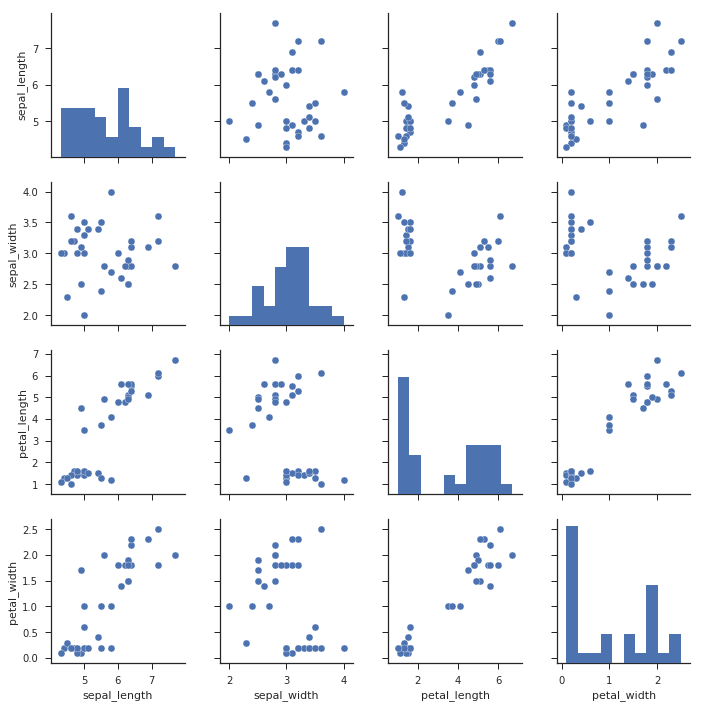

X_test


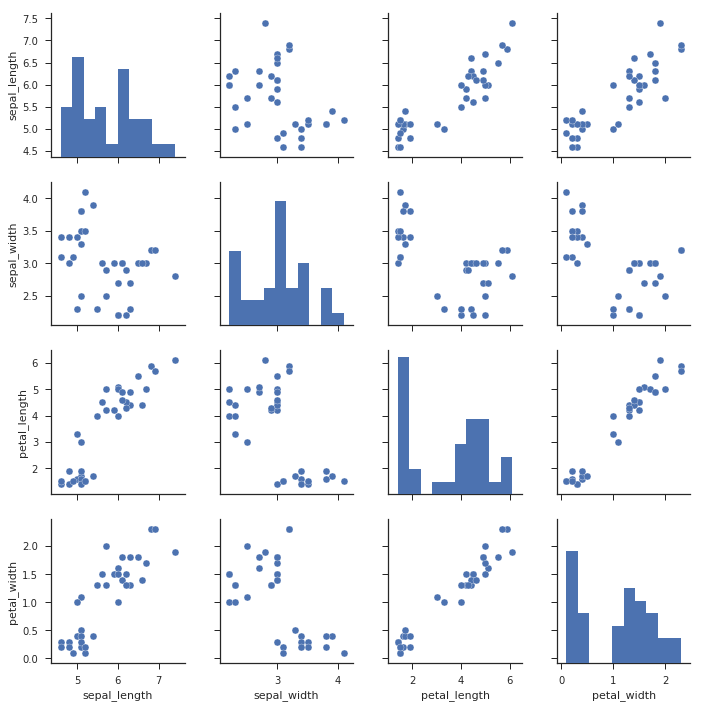

** Correlation matrix **

X_train


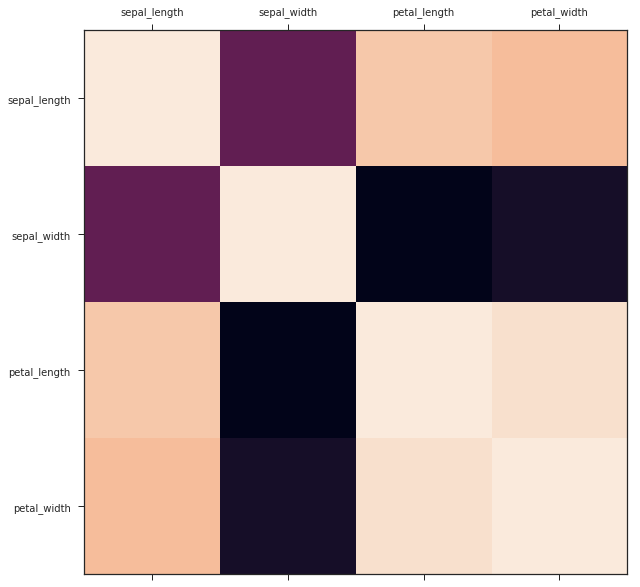

X_test


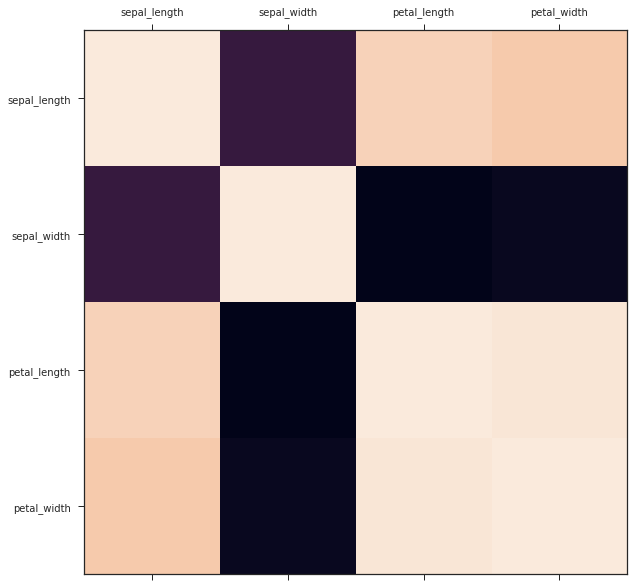

** Hierarchical clustering heatmap **

X_train

Performing hierarchical clustering using euclidean for columns and euclidean for rows
Column clustering completed in 0.0 seconds
Row clustering completed in 0.0 seconds


data_manager/utilities.py:257: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y2 = sch.linkage(D2, method=column_method, metric=column_metric)
data_manager/utilities.py:277: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y1 = sch.linkage(D1, method=row_method, metric=row_metric)


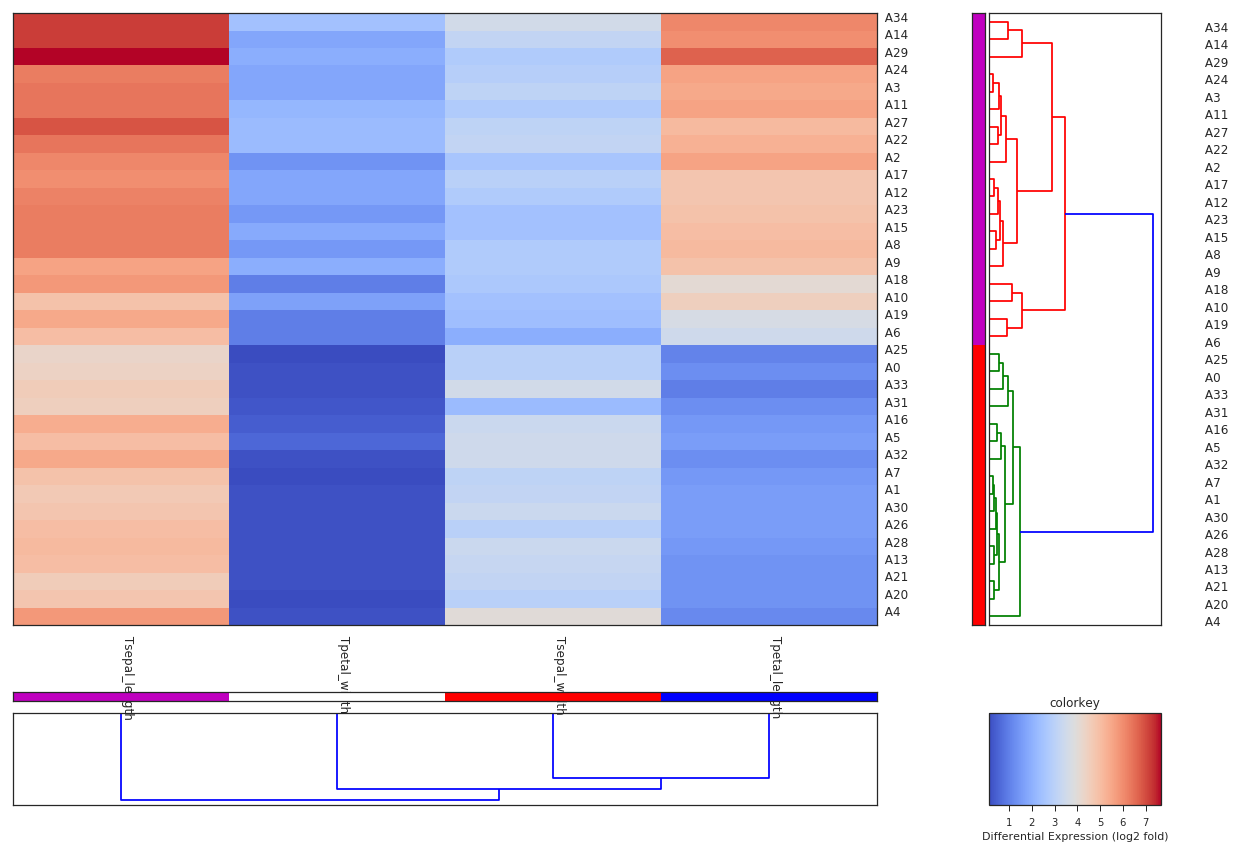

X_test

Performing hierarchical clustering using euclidean for columns and euclidean for rows
Column clustering completed in 0.0 seconds
Row clustering completed in 0.1 seconds


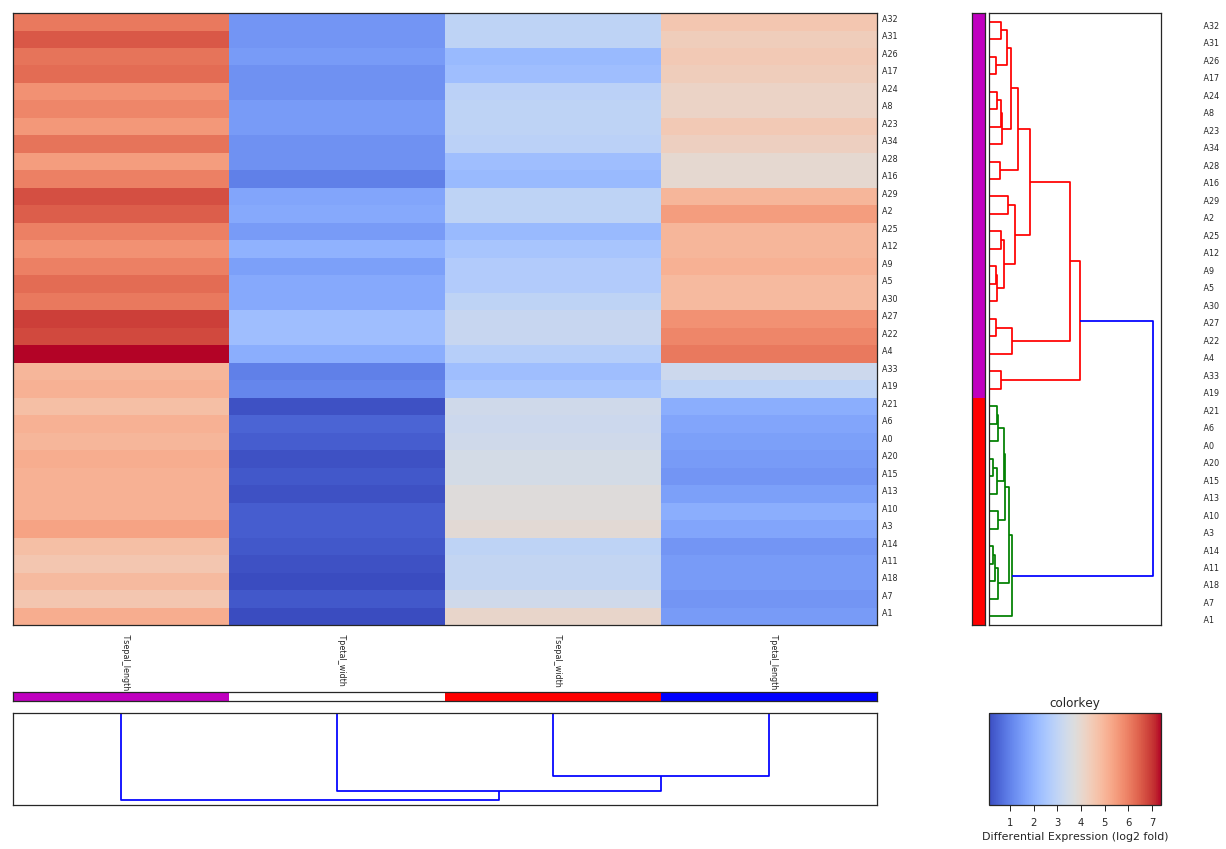

** Classes distribution **

y_train


/usr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


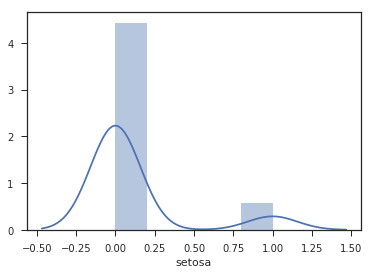

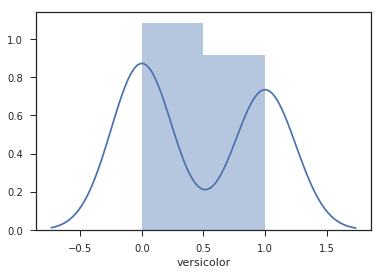

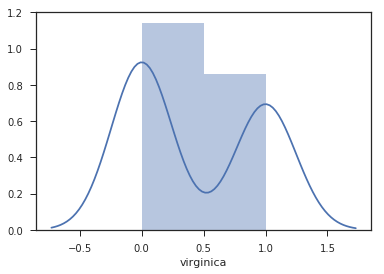

y_test


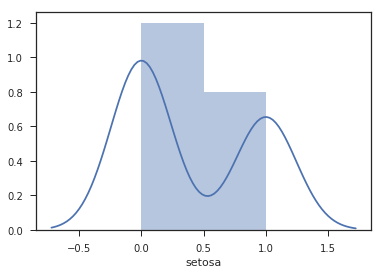

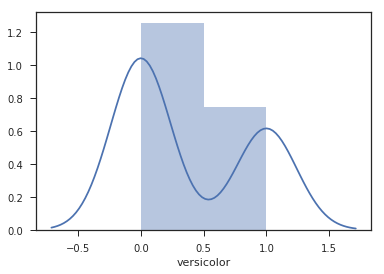

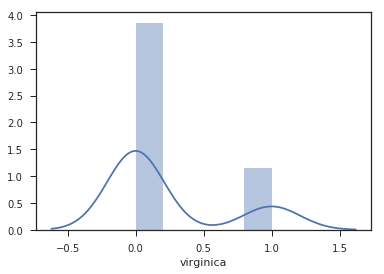

** Principal components analysis **

X_train
y_train
Explained variance ratio of the 4 components: 
 [0.93185236 0.04879616 0.013468   0.00588349]


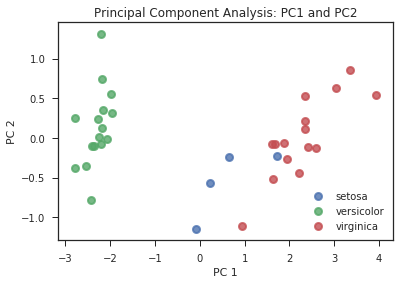

X_test
y_test
Explained variance ratio of the 4 components: 
 [0.92780796 0.05252948 0.01558235 0.00408021]


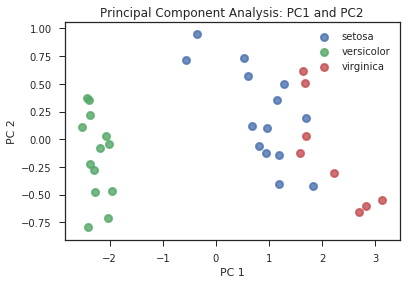

** T-distributed stochastic neighbor embedding **

X_train
y_train


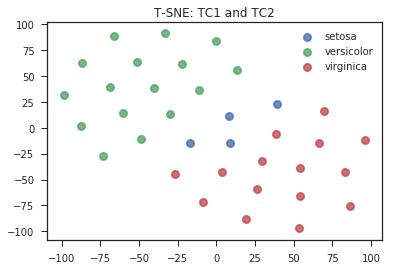

X_test
y_test


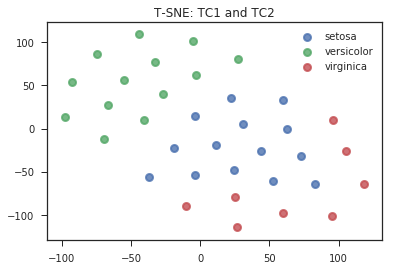

** Linear discriminant analysis **

X_train
y_train


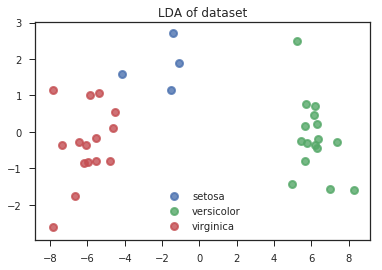

X_test
y_test


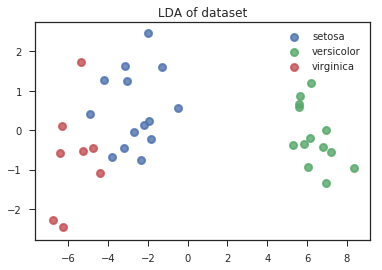

In [7]:
D.show_descriptors(processed_data=False)